In [ ]:
import os
import random
from tabnanny import verbose
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import argparse
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import tensorflow.keras.backend as K
from tensorflow.keras import initializers, layers
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [ ]:
import gc
gc.collect()

88

In [ ]:
def set_seed(seed = 100):
  tf.random.set_seed(seed)
  np.random.seed(seed)
  random.seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss.
    Using this layer as model's output can directly predict labels by using `y_pred = np.argmax(model.predict(x), 1)`
    inputs: shape=[None, num_vectors, dim_vector]
    output: shape=[None, num_vectors]
    """
    def call(self, inputs, **kwargs):
        return tf.sqrt(tf.reduce_sum(tf.square(inputs), -1) + K.epsilon())

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

    def get_config(self):
        config = super(Length, self).get_config()
        return config


def squash(vectors, axis=-1):
    """
    Vector length is treated as probability which should lies between 0 and 1. This
    function brings the vector length in the range of 0 and 1
    @param vectors: vectors to be squashed, N-dim tensor
    @param axis: the axis to squash
    @return: a Tensor with same shape as input vectors
    """
    s_squared_norm = tf.reduce_sum(tf.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / tf.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors

In [ ]:
class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_capsule] and output shape = \
    [None, num_capsule, dim_capsule]. For Dense Layer, input_dim_capsule = dim_capsule = 1.
    @param num_capsule: number of capsules in this layer
    @param dim_capsule: dimension of the output vectors of the capsules in this layer
    @param routings: number of iterations for the routing algorithm
    """
    def __init__(self, num_capsule, dim_capsule, routings=3,
                 kernel_initializer='glorot_uniform',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_initializer = initializers.get(kernel_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_capsule]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]

        # Transform matrix, from each input capsule to each output capsule, there's a unique weight as in Dense layer.
        self.W = self.add_weight(shape=[self.num_capsule, self.input_num_capsule,
                                        self.dim_capsule, self.input_dim_capsule],
                                 initializer=self.kernel_initializer,
                                 name='W')

        self.built = True

    def call(self, inputs, training=None):
        # inputs.shape=[None, input_num_capsule, input_dim_capsule]
        # inputs_expand.shape=[None, 1, input_num_capsule, input_dim_capsule, 1]
        inputs_expand = tf.expand_dims(tf.expand_dims(inputs, 1), -1)

        # Replicate num_capsule dimension to prepare being multiplied by W
        # inputs_tiled.shape=[None, num_capsule, input_num_capsule, input_dim_capsule, 1]
        inputs_tiled = tf.tile(inputs_expand, [1, self.num_capsule, 1, 1, 1])

        # Compute `inputs * W` by scanning inputs_tiled on dimension 0.
        # W.shape=[num_capsule, input_num_capsule, dim_capsule, input_dim_capsule]
        # x.shape=[num_capsule, input_num_capsule, input_dim_capsule, 1]
        # Regard the first two dimensions as `batch` dimension, then
        # matmul(W, x): [..., dim_capsule, input_dim_capsule] x [..., input_dim_capsule, 1] -> [..., dim_capsule, 1].
        # inputs_hat.shape = [None, num_capsule, input_num_capsule, dim_capsule]
        inputs_hat = tf.squeeze(tf.map_fn(lambda x: tf.matmul(self.W, x), elems=inputs_tiled))

        # Begin: Routing algorithm ---------------------------------------------------------------------#
        # The prior for coupling coefficient, initialized as zeros.
        # b.shape = [None, self.num_capsule, 1, self.input_num_capsule].
        b = tf.zeros(shape=[inputs.shape[0], self.num_capsule, 1, self.input_num_capsule])

        assert self.routings > 0, 'The routings should be > 0.'
        for i in range(self.routings):
            # c.shape=[batch_size, num_capsule, 1, input_num_capsule]
            c = tf.nn.softmax(b, axis=1)

            # c.shape = [batch_size, num_capsule, 1, input_num_capsule]
            # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
            # The first two dimensions as `batch` dimension,
            # then matmal: [..., 1, input_num_capsule] x [..., input_num_capsule, dim_capsule] -> [..., 1, dim_capsule].
            # outputs.shape=[None, num_capsule, 1, dim_capsule]
            outputs = squash(tf.matmul(c, inputs_hat))  # [None, 10, 1, 16]

            if i < self.routings - 1:
                # outputs.shape =  [None, num_capsule, 1, dim_capsule]
                # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
                # The first two dimensions as `batch` dimension, then
                # matmal:[..., 1, dim_capsule] x [..., input_num_capsule, dim_capsule]^T -> [..., 1, input_num_capsule].
                # b.shape=[batch_size, num_capsule, 1, input_num_capsule]
                b += tf.matmul(outputs, inputs_hat, transpose_b=True)
        # End: Routing algorithm -----------------------------------------------------------------------#

        return tf.squeeze(outputs)

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_capsule])

    def get_config(self):
        config = {
            'num_capsule': self.num_capsule,
            'dim_capsule': self.dim_capsule,
            'routings': self.routings
        }
        base_config = super(CapsuleLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
def PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding):
    """
    Apply Conv2D `n_channels` times and concatenate all capsules
    @param inputs: 4D tensor, shape=[None, width, height, channels]
    @param dim_capsule: the dim of the output vector of capsule
    @param n_channels: the number of types of capsules
    @return: output tensor, shape=[None, num_capsule, dim_capsule]
    """
    output = layers.Conv2D(filters=dim_capsule*n_channels, kernel_size=kernel_size, strides=strides, padding=padding,
                           name='primarycap_conv2d')(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_capsule], name='primarycap_reshape')(output)
    return layers.Lambda(squash, name='primarycap_squash')(outputs)


In [ ]:
class CapsuleNet:
  @staticmethod
  def build(input_shape,number_of_class,routing_count,batch_size,
            n_channels = 32,dim_capsule=16,
            kernels=[9],filters=[256],strides=[1]):
    
   


    input = layers.Input(shape=input_shape, batch_size=batch_size)  

    # Basic core model
    for index in range(len(kernels)):
        if index == 0 :
            conv = layers.Conv2D(filters=filters[index], 
                                kernel_size=kernels[index], 
                                strides=strides[index], 
                                padding='valid', 
                                activation='relu', 
                                name='conv'+str(index))(input)
        else:
            conv = layers.Conv2D(filters=filters[index], 
                                kernel_size=kernels[index], 
                                strides=strides[index], 
                                padding='valid', 
                                activation='relu', 
                                name='conv'+str(index))(conv)
  
   
    conv_1 = layers.Conv2D(filters=dim_capsule*n_channels, 
                             kernel_size=kernels[-1], 
                             strides=strides[-1], 
                             padding='valid', 
                             activation='relu', 
                             name='primary_capsule_conv')(conv)

   
    
    conv_2 = layers.Reshape(target_shape=[-1, dim_capsule], name='primarycap_reshape')(conv_1)
    primary_capsule = layers.Lambda(squash,name = 'primary_capsule')(conv_2)
    digitcaps = CapsuleLayer(num_capsule=number_of_class, 
                             dim_capsule=dim_capsule, 
                             routings=routing_count, 
                             name='digitcaps')(primary_capsule)    
    out_caps = Length(name='capsnet')(digitcaps)
    train_model = models.Model(input,outputs=out_caps)
    return train_model

In [ ]:

def margin_loss(y_true, y_pred):
    
    L = y_true * tf.square(tf.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * tf.square(tf.maximum(0., y_pred - 0.1))
    return tf.reduce_mean(tf.reduce_sum(L, 1))


In [ ]:

# Plot model performance
def plot_model_performance(history,name):
  plt.style.use("ggplot")
  plt.figure(figsize=(7,6))
  epoch_ran = len(history.history["loss"])
  plt.plot(np.arange(0, epoch_ran), \
           history.history["loss"], label="train_loss")
  plt.plot(np.arange(0, epoch_ran), \
           history.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, epoch_ran), \
           history.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, epoch_ran), \
           history.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()
  plt.show()
  #plt.savefig(name+'results_graph.png')

In [ ]:
# Train Capsule Network
@tf.autograph.experimental.do_not_convert
def train(model, data, args):
    """
    Training a CapsuleNet
    @param model: the CapsuleNet model
    @param data: a tuple containing training and testing data, like `((x_train, y_train), (x_test, y_test))`
    @param args: arguments
    return: The trained model
    """
    # unpacking the data
    (x_train, y_train), (x_test, y_test) = data

    # callbacks to save the best model   
    checkpoint = callbacks.ModelCheckpoint(args.save_dir + '/weights.h5', monitor='val_accuracy',
                                           save_best_only=True, save_weights_only=True, verbose=1)   
    
    # Early Stopping, if accurcay not imporving for 25 epoch, stop the training
    early_stopping =  callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, \
                       patience=50)                                            
    # compile the model
    model.compile(optimizer=optimizers.Adam(lr=args.lr),
                  loss=[margin_loss, 'mse'],
                  loss_weights=[1., args.lam_recon],run_eagerly=True,
                  metrics={'capsnet': 'accuracy'})

    # Train the model
    train_image_generator = ImageDataGenerator()  
    train_data_generator = train_image_generator.flow(x_train, y_train, batch_size=args.batch_size)
    val_image_generator = ImageDataGenerator()
    val_data_generator = val_image_generator.flow(x_test,y_test,batch_size = args.batch_size)
   
    history = model.fit(train_data_generator,
                        steps_per_epoch = int(y_train.shape[0] / args.batch_size),
                        epochs=args.epochs, 
                        verbose = 0,             
                        validation_data=val_data_generator,                         
                        callbacks=[checkpoint,early_stopping])
 
    index = history.history["val_accuracy"].index(max(history.history["val_accuracy"]))
    best_val_accuracy = history.history["val_accuracy"][index]    
    print(f"Best Validation Accuracy:{best_val_accuracy}") 
    plot_model_performance(history,args.name)
   
    return model

In [ ]:

@tf.autograph.experimental.do_not_convert
def get_model_train_test(data,args,n_channels = 32,
                                      dim_capsule=16,
                                      kernels=[9],
                                      filters=[256],
                                      strides=[1]):
  set_seed()
  (x_train,y_train),(x_test,y_test) = data
  # Build the model
  model = CapsuleNet.build(input_shape=x_train.shape[1:], 
                                      number_of_class=len(np.unique(np.argmax(y_train, 1))),
                                      routing_count=args.routings,
                                      batch_size=args.batch_size,
                                      n_channels=n_channels,
                                      dim_capsule = dim_capsule,
                                      kernels = kernels,
                                      filters= filters,
                                      strides = strides)

  model.summary()
  # Train the model
  trained_model = train(model=model, 
                        data=((x_train, y_train), (x_test, y_test)), 
                        args=args)
  #Load the weight where accuracy was maximum
  trained_model.load_weights(f'./result/weights.h5')
  # Model Training Done
  #Prediction and calculate the matrix value
 
  y_pred= trained_model.predict(x_test,batch_size=x_test.shape[0])
  
  print("*******Model Performance*************")
  print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1)) / y_test.shape[0])  

 
  result_pred = np.argmax(y_pred, axis=1) 
  result_actual = np.argmax(y_test, axis=1) 
  precision = precision_score(result_actual, result_pred)
  recall = recall_score(result_actual, result_pred)
  f1 = f1_score(result_actual, result_pred)
  tn, fp, fn, tp = confusion_matrix(result_actual, result_pred).ravel()
  fpr, tpr, thresholds = metrics.roc_curve(result_actual, result_pred)
  auc = metrics.auc(fpr, tpr)
  
  print(f"Precision:{precision}")
  print(f"recall:{recall}")
  print(f"f1:{f1}")
  print(f"AUC:{auc}")
  print(f"Sensitivity:{tp/(tp+fn)}")
  print(f"specificity:{tn/(tn+fp)}")

In [ ]:


def get_arguments():
    parser = argparse.ArgumentParser(description="Capsule Network Glaucoma Classification.")
    parser.add_argument('--epochs', default=15, type=int)
    parser.add_argument('--name', default='CapsNet', type=str)
    parser.add_argument('--batch_size', default=32, type=int)
    parser.add_argument('--lr', default=0.0001, type=float,
                            help="Initial learning rate")
    parser.add_argument('--lr_decay', default=1, type=float,
                        help="The value multiplied by lr at each epoch. Set a larger value for larger epochs")
    parser.add_argument('--lam_recon', default=0.392, type=float,
                        help="The coefficient for the loss of decoder")
    parser.add_argument('-r', '--routings', default=1, type=int,
                        help="Number of iterations used in routing algorithm. should > 0")
    parser.add_argument('--shift_fraction', default=0.1, type=float,
                        help="Fraction of pixels to shift at most in each direction.")
    parser.add_argument('--debug', action='store_true',
                        help="Save weights by TensorBoard")
    parser.add_argument('--save_dir', default='./result')
    parser.add_argument('--augmentation', default=False, type=bool)
    parser.add_argument('-t', '--testing', action='store_true',
                        help="Test the trained model on testing dataset")
    parser.add_argument('--digit', default=5, type=int,
                        help="Digit to manipulate")
    parser.add_argument('-w', '--weights', default=None,
                        help="The path of the saved weights. Should be specified when testing")
    args, unknown = parser.parse_known_args()
    print(args)

    if not os.path.exists(args.save_dir):
        os.makedirs(args.save_dir)
    
    return args  

In [ ]:
RIM_ONE_DL_DIR = '/content/gdrive/My Drive/MSC_Project/Dataset/RIM-ONE_DL_images/partitioned_randomly'
RIM_ONE_R2_DIR= '/content/gdrive/My Drive/MSC_Project/Dataset/RIMONE-db-r2'
ACRIMA_DIR = '/content/gdrive/My Drive/MSC_Project/Dataset/ACRIMA'

In [ ]:

# Resize image to HEIGHT*WIDTH
# Convert to numpy array
def process_image(data_set_dir, label_dict, width,height,histogram_eq = False):
    
    x = [] # will store images as arrays
    y = [] # store labels
    # list folders in directory
    directories = os.listdir(data_set_dir)
     
    # for each folder (train and validation) 
    for label in directories:
        
        # add class label to label dictionary
        if label not in label_dict:
            label_dict[label] = len(label_dict)
        
        # create full path for image directory 
        source_images = os.path.join(data_set_dir, label)
        images = os.listdir(source_images)
        # for each image in directory, 
        for image in images:
            #folder have .txt files which needs to be ignored
            if '.txt'not in image:
                # read the image from file, resize and add to a list
                full_size_image = cv2.imread(os.path.join(source_images, image))
                #gray_image = cv2.cvtColor(full_size_image, cv2.COLOR_BGR2GRAY)
                if histogram_eq == True:
                  full_size_image_YUW = cv2.cvtColor(full_size_image, cv2.COLOR_BGR2YUV)
                  full_size_image_YUW[:,:,0] = cv2.equalizeHist(full_size_image_YUW[:,:,0])
                  full_size_image = cv2.cvtColor(full_size_image_YUW, cv2.COLOR_YUV2BGR)
                #append the image to x
                x.append(cv2.resize(full_size_image, (width,height), 
                                                            interpolation=cv2.INTER_CUBIC))
                # add the class label to y
                y.append(label)

    data = np.array(x, dtype="float") / 255.0                
    label = np.array(y)
    
    return data,label


In [ ]:

def get_rim_one_dl(histogram_eq = False,width=64,height=64):
  class_labels = {}
  training_images,training_labels = process_image(RIM_ONE_DL_DIR+"/training_set",
                                                  class_labels,
                                                  width,height,
                                                  histogram_eq = histogram_eq)
  
  training_label = (pd.Series(training_labels).map(class_labels)).values
  training_label = to_categorical(training_label.astype('float32'))
  training_images = training_images.reshape(-1, width, height, 3).astype('float32')

  test_images,test_labels = process_image(RIM_ONE_DL_DIR+"/test_set",
                                          class_labels,
                                          width,height,
                                          histogram_eq = histogram_eq)
  
  test_label = (pd.Series(test_labels).map(class_labels)).values
  test_label = to_categorical(test_label.astype('float32'))
  test_images = test_images.reshape(-1, width, height, 3).astype('float32')

  return (training_images,training_label),(test_images,test_label)

In [ ]:

def get_rim_one_db_r2(width,height,test_train_ratio = 0.2,histogram_eq = False):
  print(f"Height:{height} Width:{width}")
  class_labels = {}
  training_images,training_labels = process_image(RIM_ONE_R2_DIR,
                                                  class_labels,
                                                  width,height,
                                                  histogram_eq = histogram_eq)
  
  training_label = (pd.Series(training_labels).map(class_labels)).values
  training_label = to_categorical(training_label.astype('float32'))
  training_images = training_images.reshape(-1, width, width, 3).astype('float32')

  X_train, X_test, y_train, y_test = train_test_split(training_images, 
                                                      training_label, 
                                                      test_size=test_train_ratio, 
                                                      random_state=100)

  return (X_train,y_train),(X_test,y_test)

In [ ]:

def get_acrima_dataset(test_train_ratio = 0.2,histogram_eq = False,width=64,height=64):
  class_labels = {}
  training_images,training_labels = process_image(ACRIMA_DIR,
                                                  class_labels,
                                                  width,height,
                                                  histogram_eq = histogram_eq)
  
  training_label = (pd.Series(training_labels).map(class_labels)).values
  training_label = to_categorical(training_label.astype('float32'))
  training_images = training_images.reshape(-1, width, width, 3).astype('float32')

  X_train, X_test, y_train, y_test = train_test_split(training_images, 
                                                      training_label, 
                                                      test_size=test_train_ratio, 
                                                      random_state=100)

  return (X_train,y_train),(X_test,y_test)

In [ ]:

def rim_one_r2_config1(width,height):

    args = get_arguments()
    args.batch_size = 32
    args.epochs = 100
    args.routings = 8
    args.name = 'RIM_ONE_V2_100_8_64'
    data = get_rim_one_db_r2(width=width,height=height)
    
    get_model_train_test(data,args)

def rim_one_r2_config2(width,height):

    args = get_arguments()
    args.batch_size = 32
    args.epochs = 100
    args.routings = 3
    args.name = 'RIM_ONE_V2_100_3_64'
    data = get_rim_one_db_r2(width=width,height=height)
    
    get_model_train_test(data,args)

def rim_one_r2_config3(width,height):

    args = get_arguments()
    args.batch_size = 32
    args.epochs = 100
    args.routings = 1
    args.name = 'RIM_ONE_V2_100_1_64'
    data = get_rim_one_db_r2(width=width,height=height)
    
    get_model_train_test(data,args)

In [ ]:

def acrima_config1(width,height):

    args = get_arguments()
    args.batch_size = 32
    args.epochs = 100
    args.routings = 8
    args.name = 'ACRIMA_100_8_64'
    data = get_acrima_dataset(width,height)
    
    get_model_train_test(data,args)    

def acrima_config2(width,height):

    args = get_arguments()
    args.batch_size = 32
    args.epochs = 100
    args.routings = 3
    args.name = 'ACRIMA_100_3_64'
    data = get_acrima_dataset(width,height)
    
    get_model_train_test(data,args)  

def acrima_config3(width,height):

    args = get_arguments()
    args.batch_size = 32
    args.epochs = 100
    args.routings = 1
    args.name = 'ACRIMA_100_1_64'
    data = get_acrima_dataset(width,height)
    
    get_model_train_test(data,args)    

In [ ]:

def rim_one_dl_config1(width,height):

    args = get_arguments()
    args.batch_size = 32
    args.epochs = 100
    args.routings = 8
    args.name = 'RIM_ONE_dl_100_8_64'
    data = get_rim_one_dl(width,height)
    
    get_model_train_test(data,args)

def rim_one_dl_config2(width,height):

    args = get_arguments()
    args.batch_size = 32
    args.epochs = 100
    args.routings = 3
    args.name = 'RIM_ONE_V2_100_3_64'
    data = get_rim_one_dl(width,height)
    
    get_model_train_test(data,args)

def rim_one_dl_config3(width,height):

    args = get_arguments()
    args.batch_size = 32
    args.epochs = 100
    args.routings = 1
    args.name = 'RIM_ONE_V2_100_1_64'
    data = get_rim_one_dl(width,height)
    
    get_model_train_test(data,args)    

Namespace(augmentation=False, batch_size=32, debug=False, digit=5, epochs=15, lam_recon=0.392, lr=0.0001, lr_decay=1, name='CapsNet', routings=1, save_dir='./result', shift_fraction=0.1, testing=False, weights=None)
Height:64 Width:64
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(32, 64, 64, 3)]         0         
                                                                 
 conv0 (Conv2D)              (32, 56, 56, 256)         62464     
                                                                 
 primary_capsule_conv (Conv2  (32, 48, 48, 512)        10617344  
 D)                                                              
                                                                 
 primarycap_reshape (Reshape  (32, 73728, 16)          0         
 )                                                               
                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)



Epoch 1: val_accuracy improved from -inf to 0.54945, saving model to ./result/weights.h5

Epoch 2: val_accuracy did not improve from 0.54945

Epoch 3: val_accuracy improved from 0.54945 to 0.60440, saving model to ./result/weights.h5

Epoch 4: val_accuracy improved from 0.60440 to 0.68132, saving model to ./result/weights.h5

Epoch 5: val_accuracy improved from 0.68132 to 0.74725, saving model to ./result/weights.h5

Epoch 6: val_accuracy did not improve from 0.74725

Epoch 7: val_accuracy improved from 0.74725 to 0.78022, saving model to ./result/weights.h5

Epoch 8: val_accuracy did not improve from 0.78022

Epoch 9: val_accuracy did not improve from 0.78022

Epoch 10: val_accuracy did not improve from 0.78022

Epoch 11: val_accuracy improved from 0.78022 to 0.86813, saving model to ./result/weights.h5

Epoch 12: val_accuracy did not improve from 0.86813

Epoch 13: val_accuracy improved from 0.86813 to 0.87912, saving model to ./result/weights.h5

Epoch 14: val_accuracy did not impr

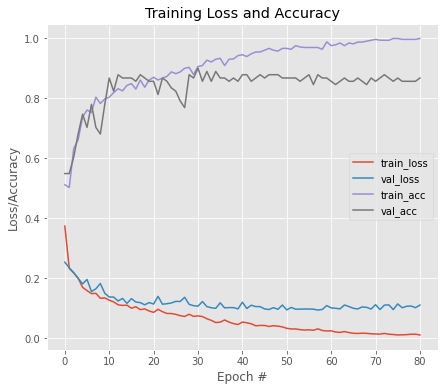

*******Model Performance*************
Test acc: 0.9010989010989011
Precision:0.8809523809523809
recall:0.9024390243902439
f1:0.8915662650602411
AUC:0.901219512195122
Sensitivity:0.9024390243902439
specificity:0.9


In [ ]:
rim_one_r2_config1(height=64,width=64)

Namespace(augmentation=False, batch_size=32, debug=False, digit=5, epochs=15, lam_recon=0.392, lr=0.0001, lr_decay=1, name='CapsNet', routings=1, save_dir='./result', shift_fraction=0.1, testing=False, weights=None)
Height:64 Width:64
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(32, 64, 64, 3)]         0         
                                                                 
 conv0 (Conv2D)              (32, 56, 56, 256)         62464     
                                                                 
 primary_capsule_conv (Conv2  (32, 48, 48, 512)        10617344  
 D)                                                              
                                                                 
 primarycap_reshape (Reshape  (32, 73728, 16)          0         
 )                                                               
                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)



Epoch 1: val_accuracy improved from -inf to 0.54945, saving model to ./result/weights.h5

Epoch 2: val_accuracy did not improve from 0.54945

Epoch 3: val_accuracy improved from 0.54945 to 0.60440, saving model to ./result/weights.h5

Epoch 4: val_accuracy improved from 0.60440 to 0.67033, saving model to ./result/weights.h5

Epoch 5: val_accuracy improved from 0.67033 to 0.71429, saving model to ./result/weights.h5

Epoch 6: val_accuracy did not improve from 0.71429

Epoch 7: val_accuracy improved from 0.71429 to 0.79121, saving model to ./result/weights.h5

Epoch 8: val_accuracy did not improve from 0.79121

Epoch 9: val_accuracy did not improve from 0.79121

Epoch 10: val_accuracy improved from 0.79121 to 0.86813, saving model to ./result/weights.h5

Epoch 11: val_accuracy did not improve from 0.86813

Epoch 12: val_accuracy did not improve from 0.86813

Epoch 13: val_accuracy did not improve from 0.86813

Epoch 14: val_accuracy did not improve from 0.86813

Epoch 15: val_accuracy 

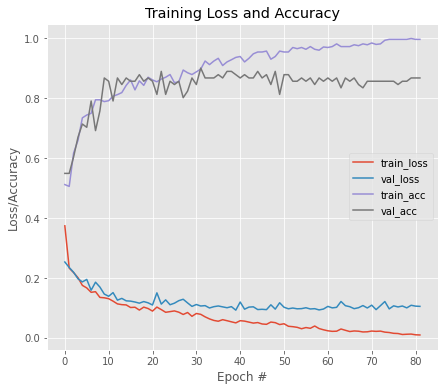

*******Model Performance*************
Test acc: 0.9010989010989011
Precision:0.9
recall:0.8780487804878049
f1:0.888888888888889
AUC:0.8990243902439025
Sensitivity:0.8780487804878049
specificity:0.92


In [ ]:
rim_one_r2_config2(height=64,width=64)

Namespace(augmentation=False, batch_size=32, debug=False, digit=5, epochs=15, lam_recon=0.392, lr=0.0001, lr_decay=1, name='CapsNet', routings=1, save_dir='./result', shift_fraction=0.1, testing=False, weights=None)
Height:64 Width:64
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(32, 64, 64, 3)]         0         
                                                                 
 conv0 (Conv2D)              (32, 56, 56, 256)         62464     
                                                                 
 primary_capsule_conv (Conv2  (32, 48, 48, 512)        10617344  
 D)                                                              
                                                                 
 primarycap_reshape (Reshape  (32, 73728, 16)          0         
 )                                                               
                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)



Epoch 1: val_accuracy improved from -inf to 0.54945, saving model to ./result/weights.h5

Epoch 2: val_accuracy did not improve from 0.54945

Epoch 3: val_accuracy improved from 0.54945 to 0.60440, saving model to ./result/weights.h5

Epoch 4: val_accuracy improved from 0.60440 to 0.68132, saving model to ./result/weights.h5

Epoch 5: val_accuracy improved from 0.68132 to 0.71429, saving model to ./result/weights.h5

Epoch 6: val_accuracy did not improve from 0.71429

Epoch 7: val_accuracy improved from 0.71429 to 0.76923, saving model to ./result/weights.h5

Epoch 8: val_accuracy did not improve from 0.76923

Epoch 9: val_accuracy did not improve from 0.76923

Epoch 10: val_accuracy improved from 0.76923 to 0.84615, saving model to ./result/weights.h5

Epoch 11: val_accuracy did not improve from 0.84615

Epoch 12: val_accuracy did not improve from 0.84615

Epoch 13: val_accuracy improved from 0.84615 to 0.85714, saving model to ./result/weights.h5

Epoch 14: val_accuracy did not impr

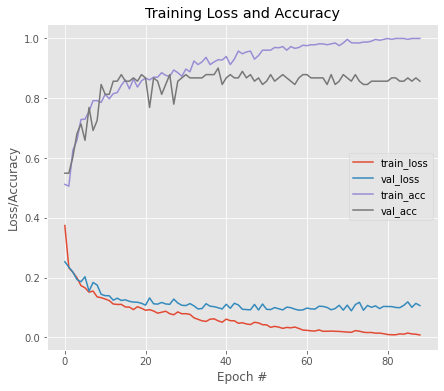

*******Model Performance*************
Test acc: 0.9010989010989011
Precision:0.9
recall:0.8780487804878049
f1:0.888888888888889
AUC:0.8990243902439025
Sensitivity:0.8780487804878049
specificity:0.92


In [ ]:
rim_one_r2_config3(height=64,width=64)

Namespace(augmentation=False, batch_size=32, debug=False, digit=5, epochs=15, lam_recon=0.392, lr=0.0001, lr_decay=1, name='CapsNet', routings=1, save_dir='./result', shift_fraction=0.1, testing=False, weights=None)
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(32, 64, 64, 3)]         0         
                                                                 
 conv0 (Conv2D)              (32, 56, 56, 256)         62464     
                                                                 
 primary_capsule_conv (Conv2  (32, 48, 48, 512)        10617344  
 D)                                                              
                                                                 
 primarycap_reshape (Reshape  (32, 73728, 16)          0         
 )                                                               
                                         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)



Epoch 1: val_accuracy improved from -inf to 0.76562, saving model to ./result/weights.h5

Epoch 2: val_accuracy did not improve from 0.76562

Epoch 3: val_accuracy improved from 0.76562 to 0.87500, saving model to ./result/weights.h5

Epoch 4: val_accuracy did not improve from 0.87500

Epoch 5: val_accuracy improved from 0.87500 to 0.92188, saving model to ./result/weights.h5

Epoch 6: val_accuracy did not improve from 0.92188

Epoch 7: val_accuracy did not improve from 0.92188

Epoch 8: val_accuracy did not improve from 0.92188

Epoch 9: val_accuracy did not improve from 0.92188

Epoch 10: val_accuracy improved from 0.92188 to 0.93750, saving model to ./result/weights.h5

Epoch 11: val_accuracy improved from 0.93750 to 0.95312, saving model to ./result/weights.h5

Epoch 12: val_accuracy did not improve from 0.95312

Epoch 13: val_accuracy did not improve from 0.95312

Epoch 14: val_accuracy did not improve from 0.95312

Epoch 15: val_accuracy did not improve from 0.95312

Epoch 16: v

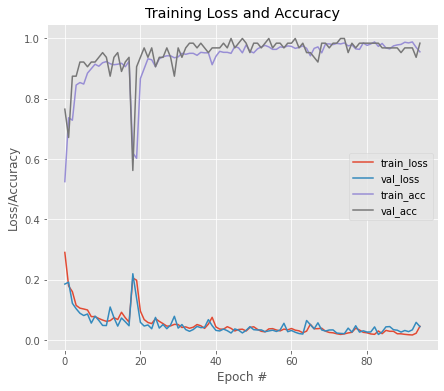

*******Model Performance*************
Test acc: 1.0
Precision:1.0
recall:1.0
f1:1.0
AUC:1.0
Sensitivity:1.0
specificity:1.0


In [ ]:
acrima_config1(height=64,width=64)

Namespace(augmentation=False, batch_size=32, debug=False, digit=5, epochs=15, lam_recon=0.392, lr=0.0001, lr_decay=1, name='CapsNet', routings=1, save_dir='./result', shift_fraction=0.1, testing=False, weights=None)
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(32, 64, 64, 3)]         0         
                                                                 
 conv0 (Conv2D)              (32, 56, 56, 256)         62464     
                                                                 
 primary_capsule_conv (Conv2  (32, 48, 48, 512)        10617344  
 D)                                                              
                                                                 
 primarycap_reshape (Reshape  (32, 73728, 16)          0         
 )                                                               
                                         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)



Epoch 1: val_accuracy improved from -inf to 0.79688, saving model to ./result/weights.h5

Epoch 2: val_accuracy did not improve from 0.79688

Epoch 3: val_accuracy improved from 0.79688 to 0.87500, saving model to ./result/weights.h5

Epoch 4: val_accuracy improved from 0.87500 to 0.89062, saving model to ./result/weights.h5

Epoch 5: val_accuracy did not improve from 0.89062

Epoch 6: val_accuracy improved from 0.89062 to 0.93750, saving model to ./result/weights.h5

Epoch 7: val_accuracy did not improve from 0.93750

Epoch 8: val_accuracy did not improve from 0.93750

Epoch 9: val_accuracy did not improve from 0.93750

Epoch 10: val_accuracy did not improve from 0.93750

Epoch 11: val_accuracy improved from 0.93750 to 0.95312, saving model to ./result/weights.h5

Epoch 12: val_accuracy did not improve from 0.95312

Epoch 13: val_accuracy did not improve from 0.95312

Epoch 14: val_accuracy did not improve from 0.95312

Epoch 15: val_accuracy did not improve from 0.95312

Epoch 16: v

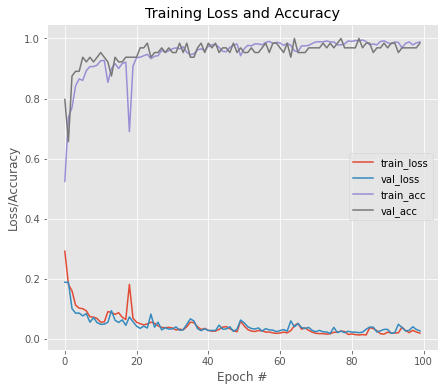

*******Model Performance*************
Test acc: 1.0
Precision:1.0
recall:1.0
f1:1.0
AUC:1.0
Sensitivity:1.0
specificity:1.0


In [ ]:
acrima_config2(height=64,width=64)

Namespace(augmentation=False, batch_size=32, debug=False, digit=5, epochs=15, lam_recon=0.392, lr=0.0001, lr_decay=1, name='CapsNet', routings=1, save_dir='./result', shift_fraction=0.1, testing=False, weights=None)
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(32, 64, 64, 3)]         0         
                                                                 
 conv0 (Conv2D)              (32, 56, 56, 256)         62464     
                                                                 
 primary_capsule_conv (Conv2  (32, 48, 48, 512)        10617344  
 D)                                                              
                                                                 
 primarycap_reshape (Reshape  (32, 73728, 16)          0         
 )                                                               
                                         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)



Epoch 1: val_accuracy improved from -inf to 0.79688, saving model to ./result/weights.h5

Epoch 2: val_accuracy did not improve from 0.79688

Epoch 3: val_accuracy improved from 0.79688 to 0.84375, saving model to ./result/weights.h5

Epoch 4: val_accuracy improved from 0.84375 to 0.90625, saving model to ./result/weights.h5

Epoch 5: val_accuracy did not improve from 0.90625

Epoch 6: val_accuracy improved from 0.90625 to 0.92188, saving model to ./result/weights.h5

Epoch 7: val_accuracy did not improve from 0.92188

Epoch 8: val_accuracy improved from 0.92188 to 0.93750, saving model to ./result/weights.h5

Epoch 9: val_accuracy did not improve from 0.93750

Epoch 10: val_accuracy did not improve from 0.93750

Epoch 11: val_accuracy did not improve from 0.93750

Epoch 12: val_accuracy did not improve from 0.93750

Epoch 13: val_accuracy did not improve from 0.93750

Epoch 14: val_accuracy did not improve from 0.93750

Epoch 15: val_accuracy did not improve from 0.93750

Epoch 16: v

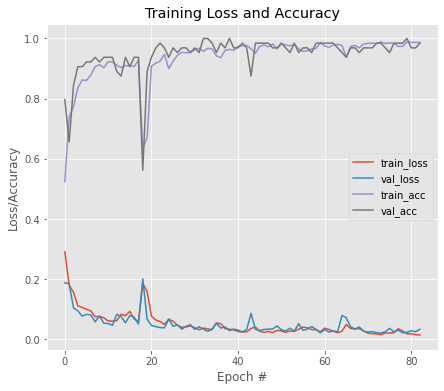

*******Model Performance*************
Test acc: 1.0
Precision:1.0
recall:1.0
f1:1.0
AUC:1.0
Sensitivity:1.0
specificity:1.0


In [ ]:
acrima_config3(height=64,width=64)

Namespace(augmentation=False, batch_size=32, debug=False, digit=5, epochs=15, lam_recon=0.392, lr=0.0001, lr_decay=1, name='CapsNet', routings=1, save_dir='./result', shift_fraction=0.1, testing=False, weights=None)
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(32, 64, 64, 3)]         0         
                                                                 
 conv0 (Conv2D)              (32, 56, 56, 256)         62464     
                                                                 
 primary_capsule_conv (Conv2  (32, 48, 48, 512)        10617344  
 D)                                                              
                                                                 
 primarycap_reshape (Reshape  (32, 73728, 16)          0         
 )                                                               
                                         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)



Epoch 1: val_accuracy improved from -inf to 0.64384, saving model to ./result/weights.h5

Epoch 2: val_accuracy did not improve from 0.64384

Epoch 3: val_accuracy did not improve from 0.64384

Epoch 4: val_accuracy did not improve from 0.64384

Epoch 5: val_accuracy did not improve from 0.64384

Epoch 6: val_accuracy improved from 0.64384 to 0.67808, saving model to ./result/weights.h5

Epoch 7: val_accuracy improved from 0.67808 to 0.76712, saving model to ./result/weights.h5

Epoch 8: val_accuracy improved from 0.76712 to 0.77397, saving model to ./result/weights.h5

Epoch 9: val_accuracy did not improve from 0.77397

Epoch 10: val_accuracy improved from 0.77397 to 0.84247, saving model to ./result/weights.h5

Epoch 11: val_accuracy improved from 0.84247 to 0.84932, saving model to ./result/weights.h5

Epoch 12: val_accuracy improved from 0.84932 to 0.89041, saving model to ./result/weights.h5

Epoch 13: val_accuracy did not improve from 0.89041

Epoch 14: val_accuracy did not impr

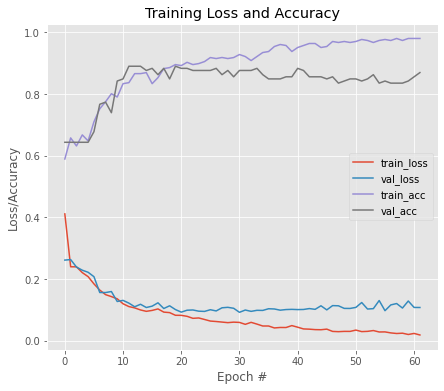

*******Model Performance*************
Test acc: 0.8904109589041096
Precision:0.9090909090909091
recall:0.7692307692307693
f1:0.8333333333333333
AUC:0.8633387888707038
Sensitivity:0.7692307692307693
specificity:0.9574468085106383


In [ ]:
rim_one_dl_config1(height = 64,width=64)

Namespace(augmentation=False, batch_size=32, debug=False, digit=5, epochs=15, lam_recon=0.392, lr=0.0001, lr_decay=1, name='CapsNet', routings=1, save_dir='./result', shift_fraction=0.1, testing=False, weights=None)
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(32, 64, 64, 3)]         0         
                                                                 
 conv0 (Conv2D)              (32, 56, 56, 256)         62464     
                                                                 
 primary_capsule_conv (Conv2  (32, 48, 48, 512)        10617344  
 D)                                                              
                                                                 
 primarycap_reshape (Reshape  (32, 73728, 16)          0         
 )                                                               
                                        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)



Epoch 1: val_accuracy improved from -inf to 0.64384, saving model to ./result/weights.h5

Epoch 2: val_accuracy did not improve from 0.64384

Epoch 3: val_accuracy did not improve from 0.64384

Epoch 4: val_accuracy did not improve from 0.64384

Epoch 5: val_accuracy did not improve from 0.64384

Epoch 6: val_accuracy improved from 0.64384 to 0.68493, saving model to ./result/weights.h5

Epoch 7: val_accuracy improved from 0.68493 to 0.76027, saving model to ./result/weights.h5

Epoch 8: val_accuracy improved from 0.76027 to 0.80822, saving model to ./result/weights.h5

Epoch 9: val_accuracy improved from 0.80822 to 0.82877, saving model to ./result/weights.h5

Epoch 10: val_accuracy improved from 0.82877 to 0.86301, saving model to ./result/weights.h5

Epoch 11: val_accuracy improved from 0.86301 to 0.86986, saving model to ./result/weights.h5

Epoch 12: val_accuracy improved from 0.86986 to 0.89041, saving model to ./result/weights.h5

Epoch 13: val_accuracy did not improve from 0.8

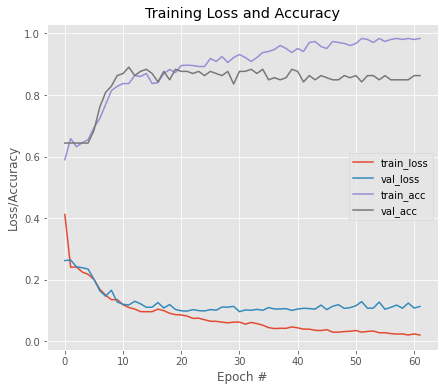

*******Model Performance*************
Test acc: 0.8904109589041096
Precision:0.8913043478260869
recall:0.7884615384615384
f1:0.836734693877551
AUC:0.8676350245499181
Sensitivity:0.7884615384615384
specificity:0.9468085106382979


In [ ]:
rim_one_dl_config2(height = 64,width=64)

Namespace(augmentation=False, batch_size=32, debug=False, digit=5, epochs=15, lam_recon=0.392, lr=0.0001, lr_decay=1, name='CapsNet', routings=1, save_dir='./result', shift_fraction=0.1, testing=False, weights=None)
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(32, 64, 64, 3)]         0         
                                                                 
 conv0 (Conv2D)              (32, 56, 56, 256)         62464     
                                                                 
 primary_capsule_conv (Conv2  (32, 48, 48, 512)        10617344  
 D)                                                              
                                                                 
 primarycap_reshape (Reshape  (32, 73728, 16)          0         
 )                                                               
                                        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)



Epoch 1: val_accuracy improved from -inf to 0.64384, saving model to ./result/weights.h5

Epoch 2: val_accuracy did not improve from 0.64384

Epoch 3: val_accuracy did not improve from 0.64384

Epoch 4: val_accuracy improved from 0.64384 to 0.65068, saving model to ./result/weights.h5

Epoch 5: val_accuracy did not improve from 0.65068

Epoch 6: val_accuracy improved from 0.65068 to 0.66438, saving model to ./result/weights.h5

Epoch 7: val_accuracy improved from 0.66438 to 0.76712, saving model to ./result/weights.h5

Epoch 8: val_accuracy improved from 0.76712 to 0.82192, saving model to ./result/weights.h5

Epoch 9: val_accuracy improved from 0.82192 to 0.86301, saving model to ./result/weights.h5

Epoch 10: val_accuracy did not improve from 0.86301

Epoch 11: val_accuracy improved from 0.86301 to 0.86986, saving model to ./result/weights.h5

Epoch 12: val_accuracy improved from 0.86986 to 0.88356, saving model to ./result/weights.h5

Epoch 13: val_accuracy did not improve from 0.8

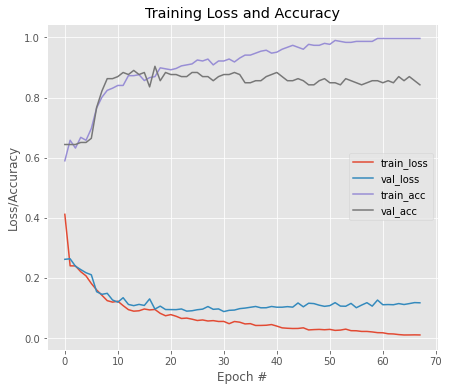

*******Model Performance*************
Test acc: 0.9041095890410958
Precision:0.9318181818181818
recall:0.7884615384615384
f1:0.8541666666666667
AUC:0.8782733224222585
Sensitivity:0.7884615384615384
specificity:0.9680851063829787


In [ ]:
rim_one_dl_config3(height = 64,width=64)